In [1]:
import os
import numpy as np
#import pandas as pd
import matplotlib.backends.backend_pdf as backend_pdf
import matplotlib.pyplot as plt
import arviz
import seaborn as sns
from ete3 import Tree
#import argparse
#import arviz as az
#import gc

from plotting import *


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Diagnostics notebook

In [2]:
#  this will be read in as variable from the script.. 
MCMC_iter = 7000
burnin = 2000
nthin = 1 # see from script/running conditions, not used for plotting
folder_runs = 'papilio/runs_v4/'#'_sim-30-leaves/runs_v2/15287225176595236/'
#folder_simdata = '_sim-30-leaves/simdata/78241558624040307/' #'BM9/simdata/3513656273068705/' #args.folder_simdata +'/'
#nnodes = 59
nxd=60
treefile = 'papilio/data/papilio_tree.nw'
pars_name = ['kalpha', 'gtheta']
rep_path = len(pars_name)+1
chains = os.listdir(folder_runs) # use all chains in data seed folder 
chains = [c for c in chains if c[0] not in ['_', '.']] # remove files starting with underscore
print(chains)
temp_name = ['' for i in range(len(chains))]


['solar-pond-25', 'peach-hill-26', 'fresh-disco-24']


In [3]:
# get levelorder tree 
phylogeny = Tree(treefile, format=1)
leafidx = []
inneridx = []
i = 0
for node in phylogeny.traverse('levelorder'):
    if node.is_leaf():
        print(node.name)
        leafidx.append(i)
    else:
        inneridx.append(i)
    i+=1
print(leafidx)
print(inneridx)
nnodes = len(leafidx) + len(inneridx)   

Papilio_gigon
Papilio_deiphobus
Papilio_xuthus
Papilio_zelicaon
Papilio_cresphontes
Papilio_troilus
Papilio_aristodemus
Papilio_glaucus
Papilio_memnon
Papilio_polyxenes
Papilio_thoas
Papilio_ambrax
Papilio_antimachus
Papilio_phestus
Papilio_polytes
Papilio_protenor
Papilio_slateri
[4, 8, 11, 12, 14, 18, 20, 21, 22, 24, 26, 27, 28, 29, 30, 31, 32]
[0, 1, 2, 3, 5, 6, 7, 9, 10, 13, 15, 16, 17, 19, 23, 25]


In [4]:
print(phylogeny)


                  /-Papilio_ambrax
               /-|
            /-|   \-Papilio_antimachus
           |  |
         /-|   \-Papilio_aristodemus
        |  |
      /-|   \-Papilio_cresphontes
     |  |
   /-|   \-Papilio_deiphobus
  |  |
  |   \-Papilio_gigon
  |
  |            /-Papilio_glaucus
  |         /-|
  |        |   \-Papilio_memnon
  |      /-|
--|     |  |      /-Papilio_phestus
  |     |  |   /-|
  |     |   \-|   \-Papilio_polytes
  |     |     |
  |   /-|      \-Papilio_polyxenes
  |  |  |
  |  |  |         /-Papilio_protenor
  |  |  |      /-|
  |  |  |   /-|   \-Papilio_slateri
   \-|  |  |  |
     |   \-|   \-Papilio_thoas
     |     |
     |      \-Papilio_troilus
     |
     |   /-Papilio_xuthus
      \-|
         \-Papilio_zelicaon


In [5]:
# read in data and MCMC chains
raw_trees = [np.genfromtxt(folder_runs + chains[i]+'/'+temp_name[i]+"tree_nodes.csv", delimiter = ",") for i in range(len(chains))]
tree_counters = [np.genfromtxt(folder_runs + chains[i]+'/'+temp_name[i]+"tree_counter.csv", delimiter = ",").astype(int) for i in range(len(chains))]
flat_trees_raw = [raw_trees[i].reshape(len(tree_counters[i]),nnodes,nxd) for i in range(len(raw_trees))]
#flat_true_tree = np.genfromtxt(folder_simdata+"flat_true_tree.csv", delimiter = ",")
super_root = [np.genfromtxt(folder_runs + chains[i]+'/'+temp_name[i]+"inference_root_start.csv", delimiter = ",") for i in range(len(chains))]
_super_root = [np.concatenate((super_root[i], super_root[i][0:2])) for i in range(len(chains))]
_super_root = np.unique(np.array(_super_root), axis=0)


# In[12]:
flat_trees = np.array([np.repeat(flat_trees_raw[i], tree_counters[i], axis=0)[burnin*rep_path:(MCMC_iter//nthin)*rep_path] for i in range(len(flat_trees_raw))])
flat_trees.shape

(3, 15000, 33, 60)

In [6]:
# create output folder
outputfolder = folder_runs
path = outputfolder+'_*'+'-'.join(chains)
if not os.path.isdir(path): 
    os.mkdir(path)
    os.mkdir(path+'/stats')


## Gelman-Rubin convergence diagnostics

In [7]:

# get rhat and ESS for all nodes and dimensions
rhats = []
esss = []
for idx in range(flat_trees.shape[2]):  # calculate for all nodes 
    innernodes = flat_trees[:,:,idx, :]
    keys = list(range(innernodes.shape[2]))
    MCMCres = arviz.convert_to_dataset({k:innernodes[:,:,i] for i,k in enumerate(keys)})
    rhats.append(arviz.rhat(MCMCres).to_array().to_numpy())
    esss.append(arviz.ess(MCMCres).to_array().to_numpy())

# save rhat for plotting
np.savetxt(path+'/stats/'+"rhats_paths.csv",np.array(rhats), delimiter=",")

## Plot traces and diagnostics paths

In [8]:
plot_traces_tree(flat_trees, inneridx, esss, rhats, outpath = path + f'/trace-innernodes_burnin={burnin}_MCMCiter={MCMC_iter}.pdf')

<Figure size 640x480 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

16


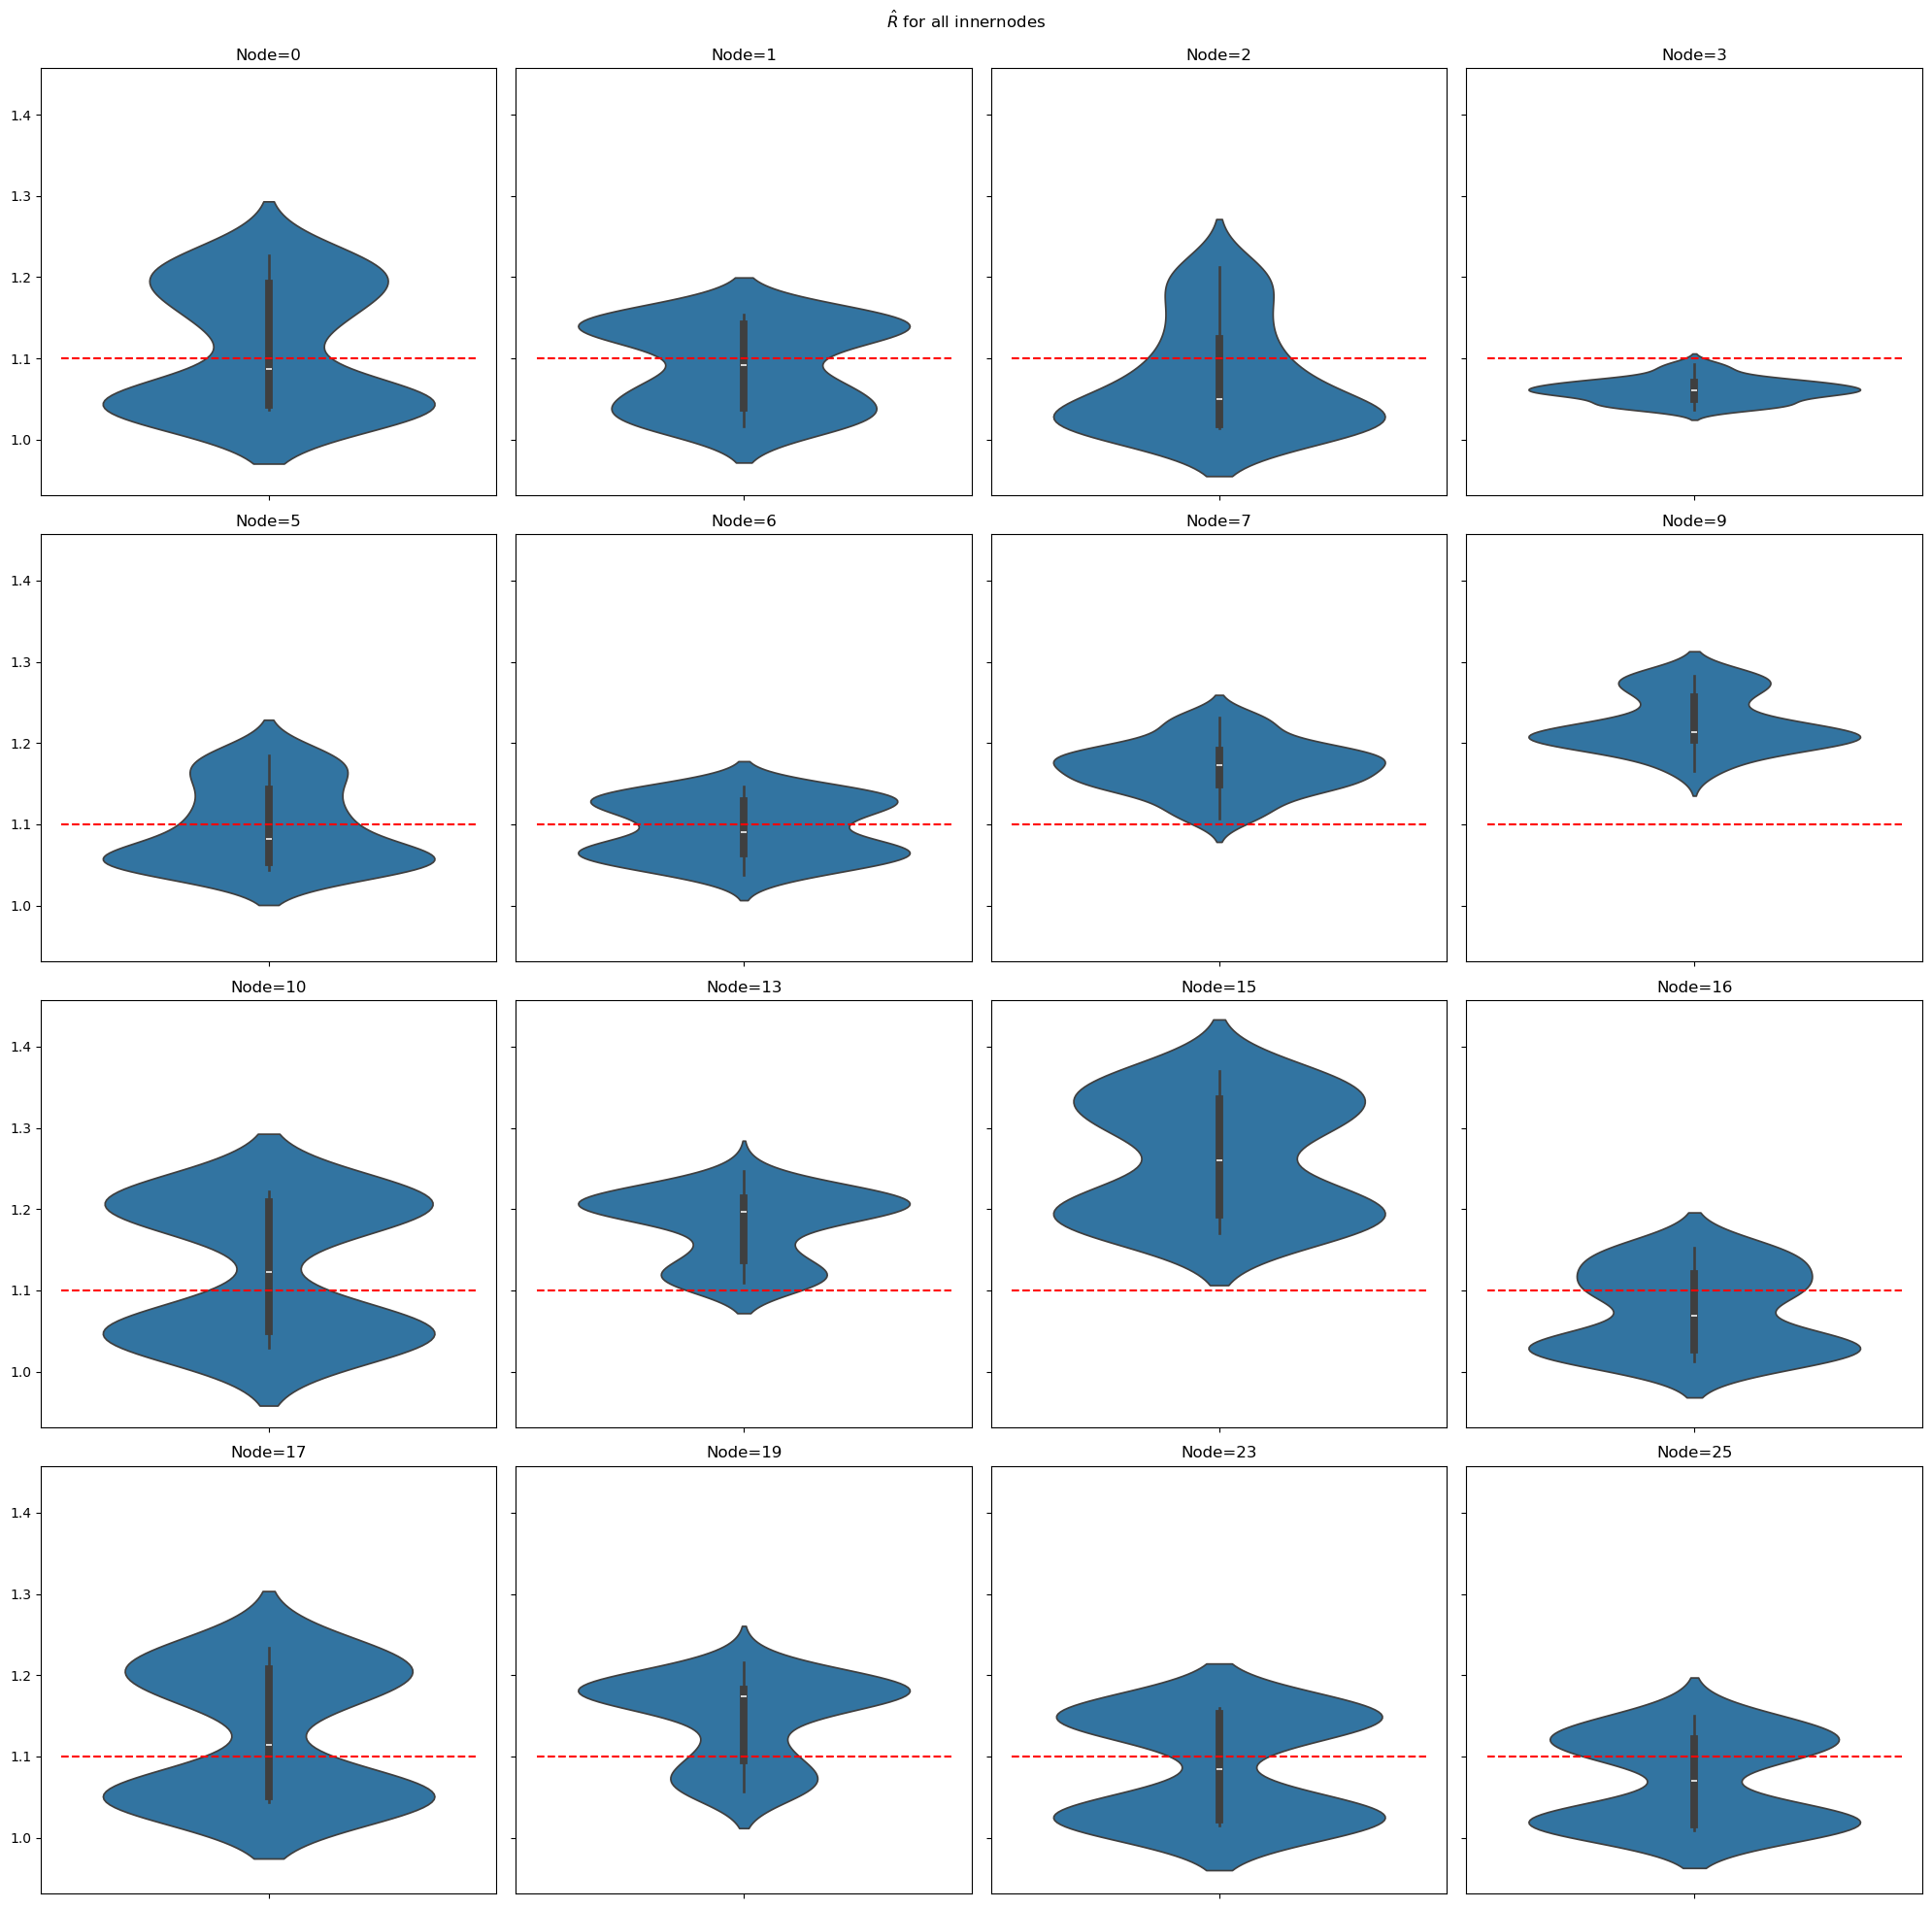

In [9]:
summary_rhat(rhats, inneridx, outpath = path + f'/summary_rhat_burnin={burnin}_MCMCiter={MCMC_iter}.pdf')

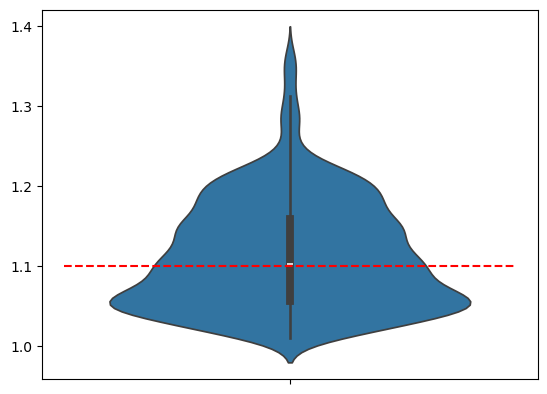

In [10]:
sns.violinplot(np.array(rhats).flatten())
plt.hlines(y=1.1, xmin=-0.5, xmax=0.5, color='red', linestyle='--')
plt.savefig(path + f'/summary_rhat_allnodes_burnin={burnin}_MCMCiter={MCMC_iter}.pdf')

## Plot posterior path

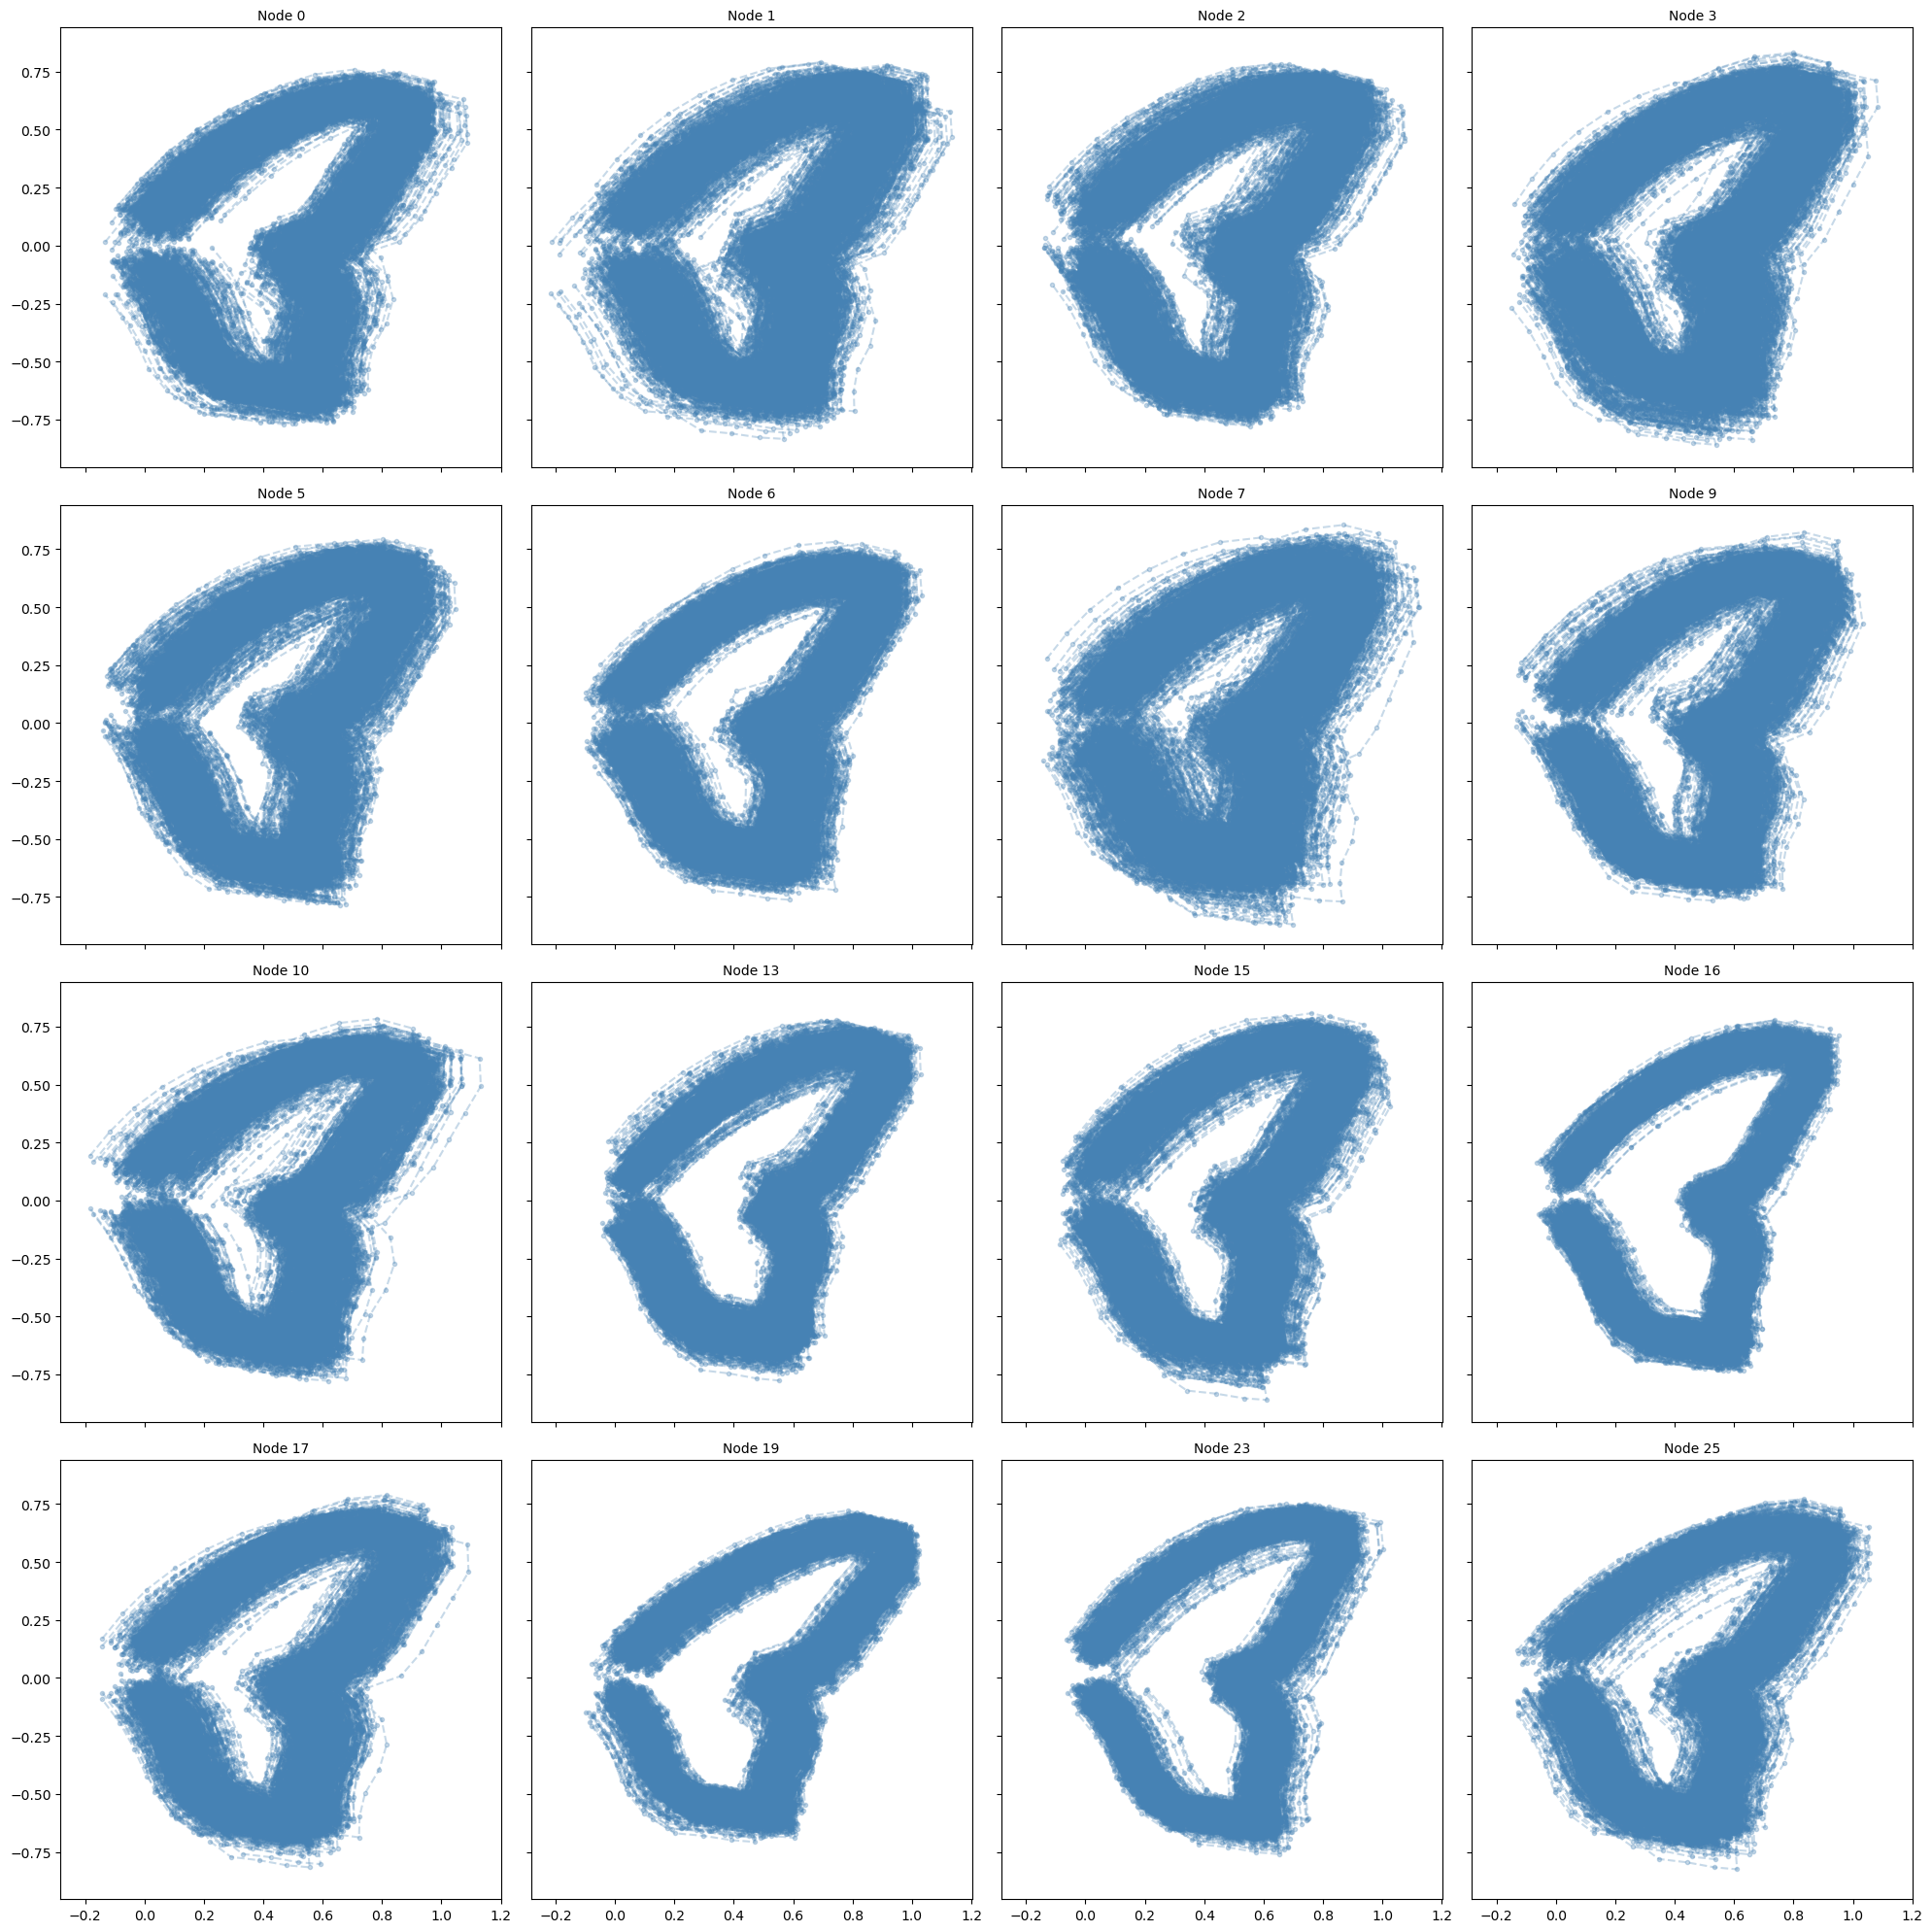

In [11]:
plot_posterior(flat_trees, inneridx, outpath = path + f'/posterior_samples_burnin={burnin}_MCMCiter={MCMC_iter}.pdf', flat_true_tree=False, sample_n=50, nxd=60)

## Plot parameters 

In [12]:
par = pars_name[0]
o = [np.genfromtxt(folder_runs + chains[i]+'/'+par+"s.csv", delimiter = ",")[:MCMC_iter] for i in range(3)]
o[1].shape

(7000,)

In [13]:
raw_pars = np.array([[np.genfromtxt(folder_runs + chains[i]+'/'+par+"s.csv", delimiter = ",")[:MCMC_iter] for i in range(len(chains))] for par in pars_name])
#raw_acceptpars = np.array([[np.genfromtxt(folder_runs + chains[i]+'/'+temp_name[i]+f"accept{par}.csv", delimiter = ",") for i in range(len(chains))] for par in pars_name])
#true_pars = [np.genfromtxt(folder_simdata +p+"_sim.csv", delimiter = ",") for p in pars_name]

In [14]:
pars = raw_pars[:,:,burnin:MCMC_iter]
pars.shape
#acceptpars = raw_acceptpars[:,:,burnin:MCMC_iter]
#acceptance_rate = np.mean(acceptpars, axis=2) # add when neccesary information is stored 

(2, 3, 5000)

In [15]:
parsdict = dict(zip(pars_name, pars)) 
MCMC_result = parsdict 
parsres = arviz.convert_to_dataset(MCMC_result)
rhat = arviz.rhat(parsres)
mcse = arviz.mcse(parsres)
ess = arviz.ess(parsres)
arviz.summary(parsres)

# save rhat for plotting
rhats_par = np.array([rhat['kalpha'], rhat['gtheta']])
np.savetxt(path+'/stats/'+"rhats_pars.csv",np.array(rhats_par), delimiter=",")

keys = pars_name
print(keys)
print([pars[i].shape for i in range(len(pars))])


['kalpha', 'gtheta']
[(3, 5000), (3, 5000)]


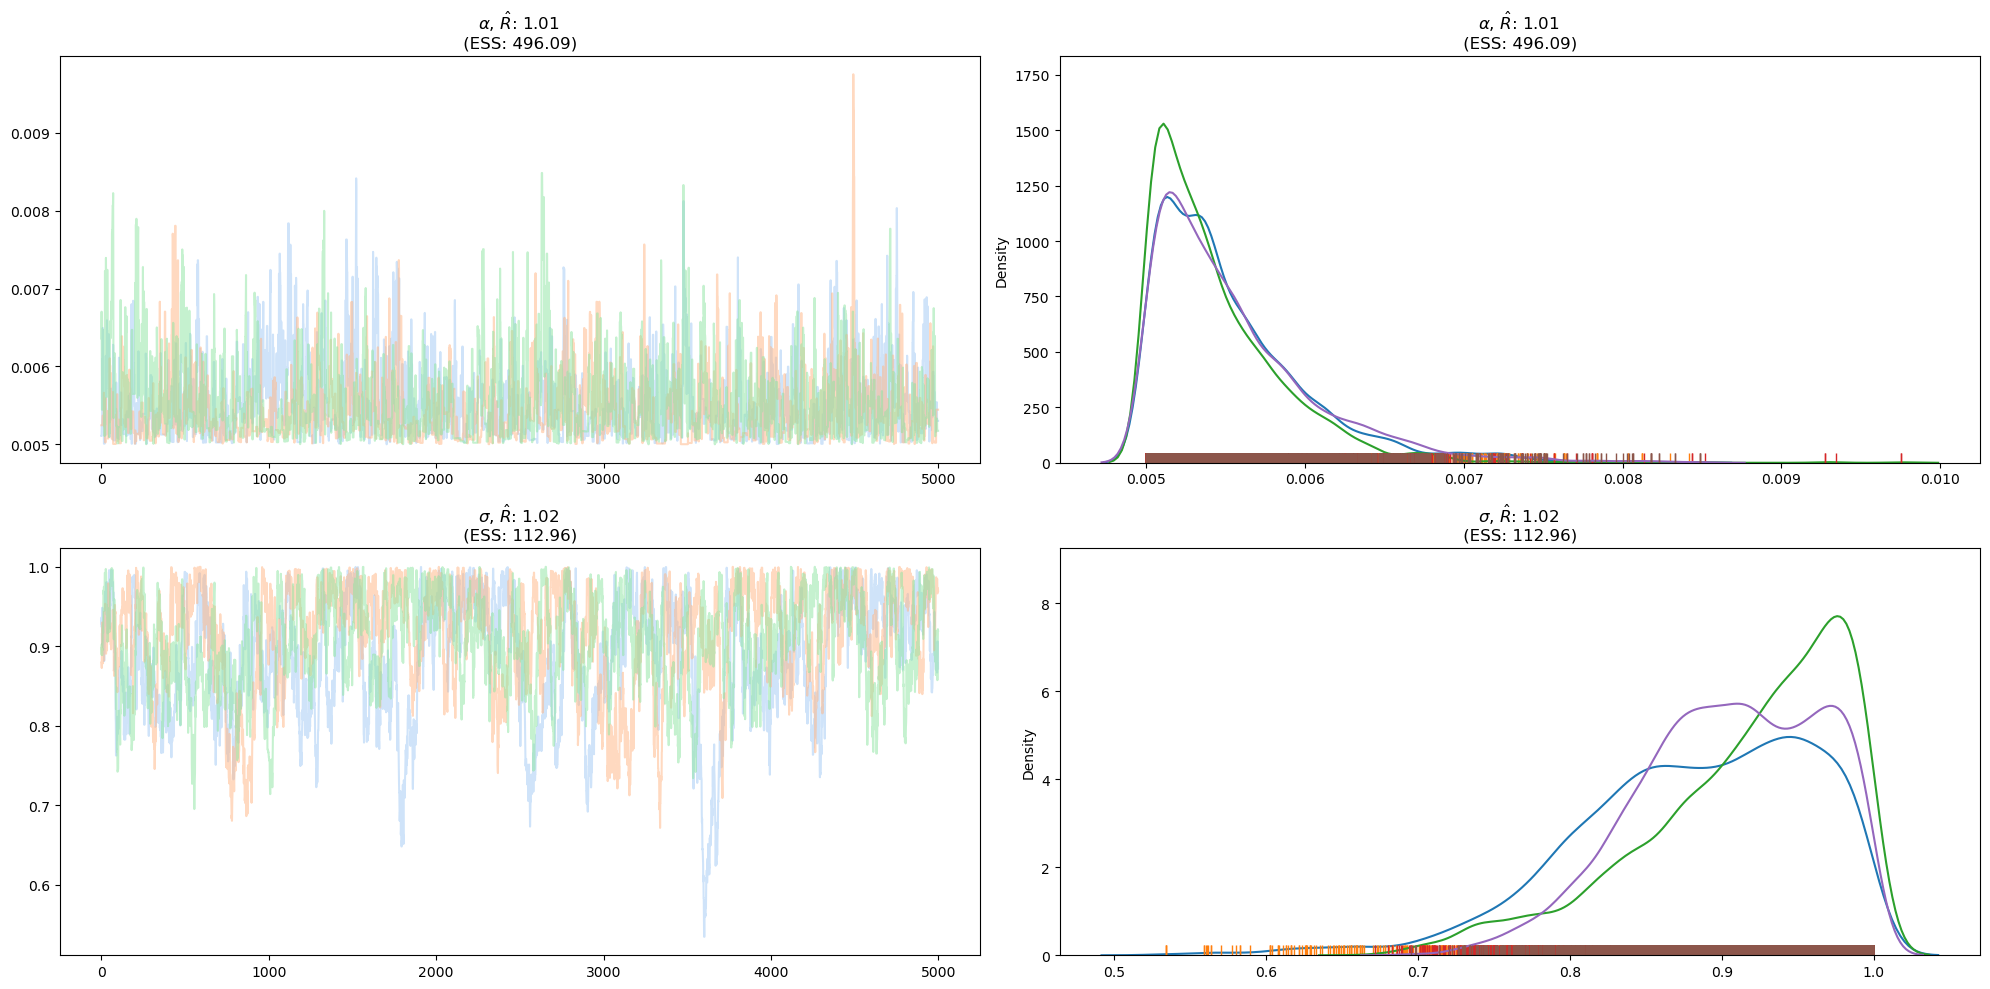

In [16]:
keys = ['kalpha', 'gtheta']
colors = sns.color_palette('pastel', len(chains))
fig, axes = plt.subplots(nrows=len(keys), ncols=2, figsize=(20,10), sharex=False)
p = 0
for i, ax in zip(range(len(axes.flat)), axes.flat): 
        if i%2 == 0: 
            for j in range(pars[p].shape[0]): #loop over chains 
                ax.plot(pars[p][j,:], color=colors[j], alpha=0.5)
            #ax.hlines(y=true_vals[p], xmin=0, xmax=pars[p].shape[1], color='skyblue')
            if keys[p] == 'kalpha':
                ax.set_title(r'${\alpha}$,'+r' $\hat{R}$: ' + f'{round(float(np.array(rhat[keys[p]])),2)} \n (ESS: {round(float(np.array(ess[keys[p]])),2)}) ')
            if keys[p] == 'gtheta':
                ax.set_title(r'${\sigma}$,'+r' $\hat{R}$: ' + f'{round(float(np.array(rhat[keys[p]])),2)} \n (ESS: {round(float(np.array(ess[keys[p]])),2)}) ')
        else:
            for j in range(pars[p].shape[0]):
                sns.kdeplot(pars[p][j,:], ax=ax)
                sns.rugplot(pars[p][j,:], ax=ax)
            #ax.axvline(x = true_vals[p], ymin = 0, ymax = 1, color='orange', label='true value')
            #ax.axvline(x = mode_est_isj[p], ymin = 0, ymax = 1, color='purple', label='isj')
            #ax.axvline(x = mode_est_sm[p], ymin = 0, ymax = 1, color='green', label='silverman')
            #ax.axvline(x = mean_est[p], ymin = 0, ymax = 1, color='skyblue', label='mean')     
            #ax.axvline(x = median_est[p], ymin = 0, ymax = 1, color='grey', label='median')
            #ax.set_title(f'{keys[p]}, rhat: {round(float(np.array(rhat[keys[p]])),2)} \n (ESS: {round(float(np.array(ess[keys[p]])),2)}) ')#
            if keys[p] == 'kalpha':
                ax.set_title(r'${\alpha}$,'+r' $\hat{R}$: ' + f'{round(float(np.array(rhat[keys[p]])),2)} \n (ESS: {round(float(np.array(ess[keys[p]])),2)}) ')
            if keys[p] == 'gtheta':
                ax.set_title(r'${\sigma}$,'+r' $\hat{R}$: ' + f'{round(float(np.array(rhat[keys[p]])),2)} \n (ESS: {round(float(np.array(ess[keys[p]])),2)}) ')
            p+=1
            #ax.legend(loc='upper right')
#fig.suptitle(f"Iter: {MCMC_iter}, Burnin: {burnin} \n", fontsize=15)
fig.tight_layout()
fig.savefig(path+f'/pars_burnin={burnin}_MCMCiter={MCMC_iter}.pdf')

